In [1]:
import os
os.chdir('/cluster/home/bdayan/girgs/benji_src/notebooks/')

import sys
sys.path.append('../')
sys.path.append('../../nemo-eva/src/')

import os
os.getcwd()


from benji_girgs import utils, generation, points, fitting, mcmc
import os
import glob
import pandas as pd
import networkit

import networkit as nk

from girg_sampling import girgs

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt

import do_feature_extract
import networkx as nx



/cluster/scratch/bdayan/GIRG_data/socfb-Duke14.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Swarthmore42.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Simmons81.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Reed98.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Bowdoin47.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-UChicago30.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-MIT.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-WashU32.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Stanford3.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-JohnsHopkins55.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Rice31.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-GWU54.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Vermont70.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Williams40.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-UCSB37.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Vanderbilt48.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-CMU.SpaceOne
/cluster/scrat

In [2]:
import jax.numpy as jnp

from jax import grad, jit, vmap
from jax import random

In [110]:
n = 1000
d=2
tau=2.5
alpha=1.3
desiredAvgDegree=100.0

points_type = points.get_points_distorted(np.array([1.0, 1.4]), cube=True)

g, edges, weights, pts, const = generation.generate_GIRG_nk(n, d, tau, alpha, desiredAvgDegree=desiredAvgDegree,
                                                            points_type=points_type)
                                                                # points_type=points.PointsCube)

g = utils.get_largest_component(g)
nk.overview(g)
n = g.numberOfNodes()

Network Properties:
nodes, edges			1000, 39886
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.079852
clustering coefficient		0.502623
min/max/avg degree		13, 941, 79.772000
degree assortativity		-0.119415
number of connected components	1
size of largest component	1000 (100.00 %)


../benji_girgs/generation.py:136: RuntimeWarning: divide by zero encountered in divide
  p_uv = np.divide(outer, dists**d)


array([[1.        , 0.98448355],
       [0.98448355, 1.        ]])

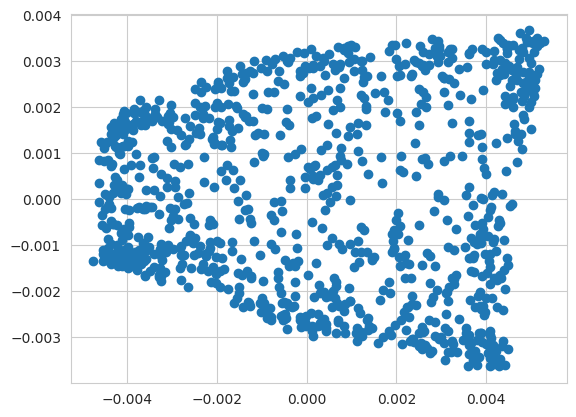

In [126]:
gnx = nk.nxadapter.nk2nx(g)

# A = nx.linalg.adjacency_matrix(gnx).todense()
A = nx.linalg.adjacency_matrix(gnx)

heat_kernel=2

if heat_kernel:
    d = heat_kernel  # integer??
    A = A.astype(np.float32)
    # if u~v then E[r_uv] is about such that p_uv=1, i.e. r_uv = (w_u w_v/n)^(1/d)
    # Then heat kernel thing says that we want W_ij = exp(-r_ij^2 / T) for some param T
    dd = nk.centrality.DegreeCentrality(g).run().scores()
    n = g.numberOfNodes()
    T = 4.0 # ??
    for i, j in g.iterEdges():
        r_ij = (dd[i] * dd[j] / n)**(1/d)
        A[i, j] = np.exp(-r_ij**2 / T)
        A[j, i] = A[i, j]

    D = A.sum(axis=1)

D_h = D**(0.5)
D_hi = D**(-0.5)



S = scipy.sparse.diags(D_hi) @ A @ scipy.sparse.diags(D_hi)

w, V = scipy.sparse.linalg.eigsh(S, k=sparse_evals, which="LM")
Phi = scipy.sparse.diags(D_hi) @ V
Psi = scipy.sparse.diags(D_h) @ V

w = np.flip(w)

def diff_map(i, t):
    return Phi[i, -2::-1] * (w[1:] ** t)

pts_dm = np.array([diff_map(i, 10) for i in range(g.numberOfNodes())])
pts_dm = pts_dm[:, :2]


np.corrcoef(pts_dm[:, 0], pts[:, 1])
plt.scatter(pts_dm[:, 0], pts_dm[:, 1])

# vs gamma=0.9 gets 0.98637293?
# T = 3.0 get 0.98447712
# T = 5.0 0.9834272

In [112]:
import scipy
gamma=0.0
Iweighting=0.5
sparse_evals=10

M_tilde = scipy.sparse.diags(1 / D) @ A @ scipy.sparse.diags(D ** (-gamma))
M_tilde = scipy.sparse.diags(np.array(1 / M_tilde.sum(axis=-1)).squeeze()) @ M_tilde
M_tilde = (1 - Iweighting) * M_tilde + Iweighting * np.eye(M_tilde.shape[0])
a, B = scipy.sparse.linalg.eigs(M_tilde, k=sparse_evals, which="LR")

a, B = np.real(a), np.real(B)

idx = np.argsort(a)[::-1]
a = a[idx]
B = B[:, idx]

def diff_map(i, t):
    return B[i, 1:] * a[1:] ** t

In [113]:
pts_dm = np.array([diff_map(i, 10) for i in range(g.numberOfNodes())])
pts_dm = pts_dm[:, :2]

In [117]:
a

array([1.        , 0.88630335, 0.84840219, 0.81988587, 0.80112052,
       0.78021198, 0.74369991, 0.73447128, 0.73272878, 0.71902552])

array([[1.        , 0.95033731],
       [0.95033731, 1.        ]])

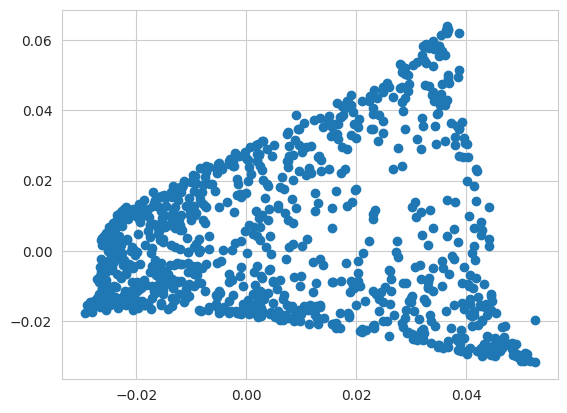

In [114]:

np.corrcoef(pts_dm[:, 0], pts[:, 1])
plt.scatter(pts_dm[:, 0], pts_dm[:, 1])

array([[1.        , 0.98637293],
       [0.98637293, 1.        ]])

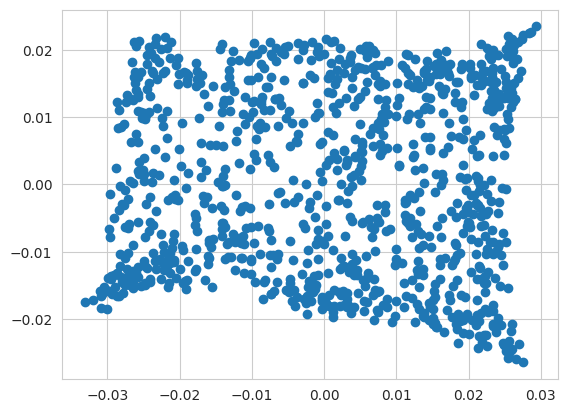

In [121]:
ds = 2
a, B, _, diff_map = utils.get_diffmap(g, sparse_evals=10, ds=ds, gamma=0.9)
pts_dm = np.array([diff_map(i, 10) for i in range(g.numberOfNodes())])
pts_dm = pts_dm[:, :ds]

np.corrcoef(pts_dm[:, 0], pts[:, 1])
plt.scatter(pts_dm[:, 0], pts_dm[:, 1])

array([[1.        , 0.97540082],
       [0.97540082, 1.        ]])

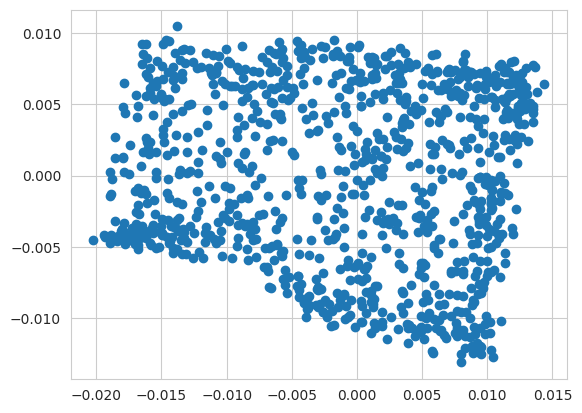

In [127]:
ds = 2
a, B, _, diff_map = utils.get_diffmap(g, sparse_evals=10, ds=ds, gamma=0.0)
pts_dm = np.array([diff_map(i, 10) for i in range(g.numberOfNodes())])
pts_dm = pts_dm[:, :ds]

np.corrcoef(pts_dm[:, 0], pts[:, 1])
plt.scatter(pts_dm[:, 0], pts_dm[:, 1])

In [106]:
np.corrcoef(pts_dm[:, 0], pts[:, 1])

array([[1.        , 0.98762362],
       [0.98762362, 1.        ]])

In [76]:
# weights = np.array(utils.graph_degrees_to_weights(g))
# a, B, pts_dm = utils.get_diffmap_and_points(g, process='restrict_uniform_edges', ds=2)
# pts_dm = points.PointsCube(pts_dm)
# MC = mcmc.MCMC_girg(g, weights, alpha, const, pts_dm.copy(), pool=True, graph_name='n=1500 2D GIRG', failure_prob=0.3, cl_mixin_prob=0.5)

In [77]:
# plt.scatter(MC.pts[:, 0], pts[:, 0])

In [78]:
import importlib
importlib.reload(utils)

<module 'benji_girgs.utils' from '../benji_girgs/utils.py'>

In [81]:
ds = 2
a, B, _, diff_map = utils.get_diffmap(g, sparse_evals=10, ds=ds, gamma=0.9)
pts_dm = np.array([diff_map(i, 10) for i in range(g.numberOfNodes())])
pts_dm = pts_dm[:, :ds]
np.corrcoef(pts_dm[:, 0], pts[:, 0])
np.corrcoef(pts_dm[:, 0], pts[:, 1])

a, B, _, diff_map = utils.get_diffmap(g, sparse_evals=10, ds=ds, gamma=0.0)
pts_dm = np.array([diff_map(i, 10) for i in range(g.numberOfNodes())])
pts_dm = pts_dm[:, :ds]
np.corrcoef(pts_dm[:, 0], pts[:, 0])
np.corrcoef(pts_dm[:, 0], pts[:, 1])


a, B, _, diff_map = utils.get_diffmap(g, sparse_evals=10, ds=ds, gamma=0.0, heat_kernel=ds)
pts_dm = np.array([diff_map(i, 10) for i in range(g.numberOfNodes())])
pts_dm = pts_dm[:, :ds]
np.corrcoef(pts_dm[:, 0], pts[:, 0])
np.corrcoef(pts_dm[:, 0], pts[:, 1])

array([[ 1.        , -0.98228761],
       [-0.98228761,  1.        ]])

array([[1.        , 0.10535228],
       [0.10535228, 1.        ]])

array([[ 1.        , -0.64495159],
       [-0.64495159,  1.        ]])

array([[1.        , 0.75949037],
       [0.75949037, 1.        ]])

array([[ 1.        , -0.60274288],
       [-0.60274288,  1.        ]])

array([[ 1.        , -0.67749506],
       [-0.67749506,  1.        ]])

In [44]:
dd = nk.centrality.DegreeCentrality(g).run().scores()
n = g.numberOfNodes()
T = 1.0
for i, j in g.iterEdges():
    r_ij = (dd[i] * dd[j] / n)**(1/d)
    break

In [57]:
gnx = nk.nxadapter.nk2nx(g)

# A = nx.linalg.adjacency_matrix(gnx).todense()
A = nx.linalg.adjacency_matrix(gnx)

heat_kernel=2
if heat_kernel:
    A = A.astype(np.float32)
    d = heat_kernel  # integer??
    # if u~v then E[r_uv] is about such that p_uv=1, i.e. r_uv = (w_u w_v/n)^(1/d)
    # Then heat kernel thing says that we want W_ij = exp(-r_ij^2 / T) for some param T
    dd = nk.centrality.DegreeCentrality(g).run().scores()
    n = g.numberOfNodes()
    T = 1.0 # ??
    for i, j in g.iterEdges():
        r_ij = (dd[i] * dd[j] / n)**(1/d)
        A[i, j] = np.exp(-r_ij**2 / T)
        A[j, i] = A[i, j]
        print(A[i, j])

8.666894e-06
0.003903038
0.0068603284
1.5233707e-05
0.00023264428
7.869709e-12
0.00078958744
0.000109673805
1.8293242e-17
0.0015246354
0.028099598
0.0005421326
3.8772137e-19
8.2655447e-07
2.6753912e-07
0.00033883407
0.00044921902
0.0002807629
0.017562313
0.0015246354
1.1461816e-11
0.00086740893
0.003903038
0.00033883407
0.0035528685
0.0015246354
0.0003722295
4.2841642e-05
4.7025065e-07
1.9261256e-06
0.00033883407
0.012058325
0.00019277247
9.8844984e-29
8.2724066e-05
0.0068603284
2.2168686e-07
0.00017547746
1.9133814e-22
0.0010468182
0.0004934939
9.080195e-07
0.009991705
0.0015246354
2.941517e-05
0.021194788
4.930846e-06
1.9261256e-06
0.00030843483
0.00753648
1.2018367e-10
2.0163033e-09
0.005174565
0.00095290056
1.815713e-35
0.002679835
5.940842e-10
3.3771126e-12
0.01455239
9.0726635e-09
0.0132467905
0.003234115
0.00033883407
0.0003722295
1.6583075e-27
7.1815166e-06
0.0005421326
3.535223e-15
0.00086740893
0.00021177207
0.002679835
5.170273e-05
0.004710317
0.00753648
0.00071874785
2.7936

In [58]:
A.sum(axis=1)

array([2.12480381e-01, 7.72862077e-01, 1.91368818e-01, 3.50022483e+00,
       9.13814545e-01, 9.92371202e-01, 4.81197977e+00, 4.80136462e-02,
       1.15868115e+00, 1.14813223e-02, 5.01262712e+00, 2.60040236e+00,
       6.01538777e-01, 1.08611619e+00, 6.39700222e+00, 9.92049575e-01,
       3.09174061e+00, 2.31249142e+00, 1.57246798e-01, 3.07778031e-01,
       2.89709330e+00, 2.34451127e+00, 1.09419322e+00, 2.18541574e+00,
       1.92739442e-02, 7.34200716e-01, 3.25303316e+00, 1.00919890e+00,
       9.77496952e-02, 8.08186710e-01, 1.29354060e+00, 1.05658340e+00,
       7.39862442e+00, 2.13508439e+00, 5.57207108e-01, 2.48425746e+00,
       1.77054489e+00, 3.47250223e+00, 3.05183351e-01, 3.18078613e+00,
       5.19331455e-01, 1.13282621e-01, 7.00435936e-01, 9.66759995e-02,
       4.69824881e-04, 1.55591881e+00, 1.26447096e-01, 8.22799206e-01,
       1.42438757e+00, 1.27987325e-01, 2.30162239e+00, 2.91855693e+00,
       2.75124852e-02, 7.71402493e-02, 2.52037501e+00, 1.23159349e+00,
      

In [52]:
A.sum()

0

In [51]:
nk.overview(g)

Network Properties:
nodes, edges			1000, 38952
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.077982
clustering coefficient		0.476468
min/max/avg degree		15, 851, 77.904000
degree assortativity		-0.103177
number of connected components	1
size of largest component	1000 (100.00 %)


In [47]:
dd[i], dd[j]

(94.0, 124.0)

<Figure size 640x480 with 0 Axes>

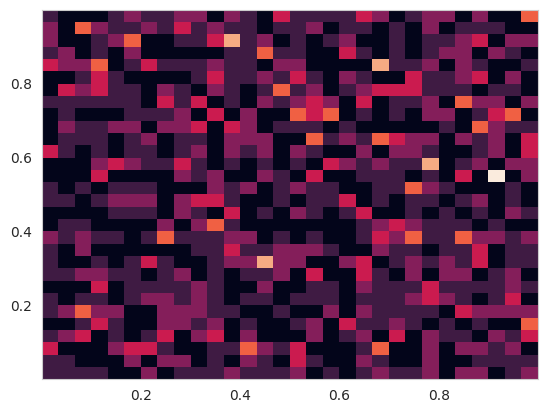

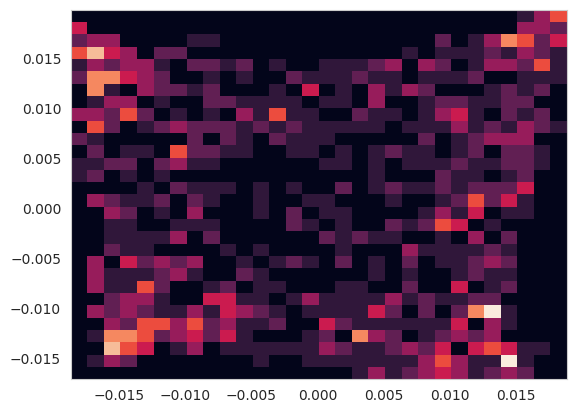

In [24]:
_ = plt.hist2d(pts[:, 0], pts[:, 1], bins=30)
plt.figure()
_ = plt.hist2d(pts_dm[:, 0], pts_dm[:, 1], bins=30)

<Figure size 640x480 with 0 Axes>

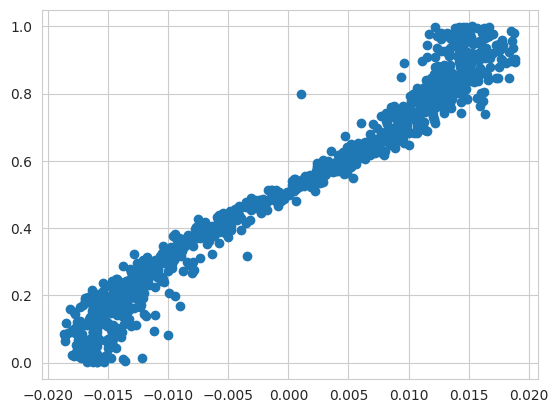

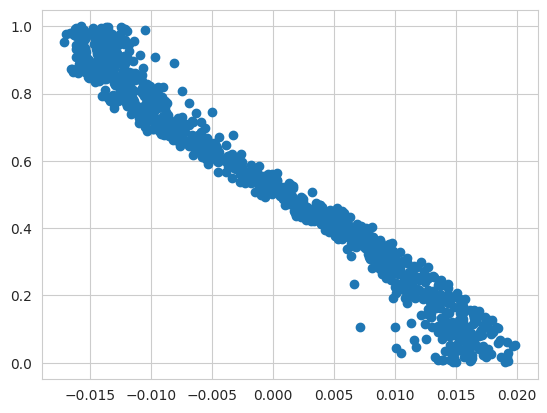

In [25]:
plt.scatter(pts_dm[:, 0], pts[:, 1])
plt.figure()
plt.scatter(pts_dm[:, 1], pts[:, 0])

In [37]:
g = nk.Graph(5)
g.addEdge(0, 1)
g.addEdge(1, 2)
g.addEdge(2, 3)
g.addEdge(0, 2)

gnx = nk.nxadapter.nk2nx(g)
nx.linalg.adjacency_matrix(gnx).todense()

array([[0, 1, 1, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 1, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0]])

In [4]:
key = random.PRNGKey(0)
x = random.normal(key, (10,))
key


2023-07-17 14:08:38.608436: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array([0, 0], dtype=uint32)

Array([-0.3721109 ,  0.26423115, -0.18252768, -0.7368197 , -0.44030377,
       -0.1521442 , -0.67135346, -0.5908641 ,  0.73168886,  0.5673026 ],      dtype=float32)

In [5]:
size=3000
x = random.normal(key, (size, size), dtype=jnp.float32)

In [6]:
%timeit jnp.dot(x, x.T).block_until_ready()

244 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
import numpy as np
x = np.random.normal(size=(size, size)).astype(np.float32)
%timeit jnp.dot(x, x.T).block_until_ready()

208 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
